# 前準備

In [1]:

import os
import sys

from base.model.Temperature import Spe

"""
このnotebookがbaseフォルダを読めるようになるための処理
"""

root_rel = '../../'

# 相対パスを絶対パスに変換してsys.pathに追加
root_abs = os.path.abspath(root_rel)
if root_abs not in sys.path:
    sys.path.append(root_abs)
print(root_abs)



base.model.Temperature.Spe     is imported
/Users/ishizawaosamu/work/ipynb/BL10XU_notebook/base


In [2]:

# ライブラリの取り込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import h5py

from tqdm import tqdm

In [3]:
# ファイルpath

dist_list = []
calib_list = []
spe_list = []

data_root = "/Users/ishizawaosamu/work/ipynb/BL10XU_notebook/base/data/analyze_calib/"

for path in os.listdir(data_root):
    if "calib" in path:
        calib_path = os.path.join(data_root + path)
        calib_list.append(calib_path)
    elif "dist" in path:
        dist_path = os.path.join(data_root + path)
        dist_list.append(dist_path)
    elif "spe" in path:
        spe_path = os.path.join(data_root + path)
        spe_list.append(spe_path)
        
dist_list.sort()
calib_list.sort()
spe_list.sort()

In [4]:
for i in range(len(dist_list)):
    print(f"{i}: {dist_list[i][-50:]}, \n\t{calib_list[i][-50:]}, \n\t\t{spe_list[i][-50:]}\n")

0: base/data/analyze_calib/OIbDia06_  04_dist(20).csv, 
	ok/base/data/analyze_calib/OIbDia06_  04_calib.csv, 
		tebook/base/data/analyze_calib/1_OIbDia06_  04.spe

1: lib/rotated_(-3e-1)OIMgO14_  02(v3.0)_dist(20).csv, 
	_calib/rotated_(-3e-1)OIMgO14_  02(v3.0)_calib.csv, 
		notebook/base/data/analyze_calib/2_OIMgO14  02.spe

2: lib/rotated_(5e-1)OIbDia06_  04(v3.0)_dist(20).csv, 
	calib/rotated_(5e-1)OIbDia06_  04(v3.0)_calib1.csv, 
		base/data/analyze_calib/3_OIbDia06_  04_copied.spe

3: alib/rotated_(6e-1)ERFeO09_  06(v3.0)_dist(50).csv, 
	e_calib/rotated_(6e-1)ERFeO09_  06(v3.0)_calib.csv, 
		otebook/base/data/analyze_calib/4_ERFeO09_  06.spe



# 関数定義

In [5]:
def show_hdf5_hierarchy(f, indent=0, path=""):
    for key in f.keys():
        print(" " * indent + "/" + key)  # グループ名を出力
        current_path = path + "/" + key
        if isinstance(f[key], h5py.Group): # もしkey先がgroupの場合
            show_hdf5_hierarchy(f[key], indent + 4, path=current_path)  # グループ内のさらに深い階層を出力
        else:
            print(" " * indent + f" --> path:  \"{current_path}\"")
            print(" " * indent + f"       L {type(f[key])}")
            dataset = f[key]
            
            if dataset.shape == (): # スカラー(単一値)の場合
                value = str(dataset[()]) # スカラーの場合の読み取り
            else:
                value = str(f.get(key)[0])
                
            if len(value) > 20:
                print(" " * indent + f"       L {value[:20]}")
            else:
                print(" " * indent + f"       L {value}")

In [6]:
# HDF5ファイルのデータpath一覧を取得する
class Hdf5Path:
    def __init__(self, *, hdf: h5py.File):
        self.f = hdf
        self.path_num = 0
        self.path_list = []
        self.get_hdf5_all_path(f=self.f)
        
    def get_hdf5_all_path(self, f, path=""):
        for key in f.keys():
            current_path = path + "/" + key
            if isinstance(f[key], h5py.Group): # もしkey先がgroupの場合
                self.get_hdf5_all_path(f[key], path=current_path)
            else:
                print(f"{self.path_num: <2}: {current_path}")
                self.path_num += 1
                self.path_list.append(current_path)


# ファイルを読み込む

In [7]:
from model.Temperature.Spe import SpeFile
from model.Temperature.T_calib import T_calib
from model.Temperature.T_dist import T_dist

model.Temperature.Spe          is imported
model.Temperature.T_calib      is imported
model.Temperature.T_dist       is imported.


In [8]:
# 実験のメタデータを得るためにSpeFileも読み込んでおく。hdfには保存しない
spes = []
for i in range(len(spe_list)):
    spes.append(SpeFile(filepath=spe_list[i]))

ファイル: /Users/ishizawaosamu/work/ipynb/BL10XU_notebook/base/data/analyze_calib/1_OIbDia06_  04.spe
ファイル: /Users/ishizawaosamu/work/ipynb/BL10XU_notebook/base/data/analyze_calib/2_OIMgO14  02.spe
ファイル: /Users/ishizawaosamu/work/ipynb/BL10XU_notebook/base/data/analyze_calib/3_OIbDia06_  04_copied.spe
ファイル: /Users/ishizawaosamu/work/ipynb/BL10XU_notebook/base/data/analyze_calib/4_ERFeO09_  06.spe


In [9]:
# 実験時期と校正時期
for i in range(len(spes)):
    print(f"{spes[i].basename} {spes[i].filenum} : {spes[i].date_time} / {spes[i].calibration_date}")

OIbDia06_ 4 : 2023-11-08 17:06:43.128492+09:00 / 2023-09-15T16:00:05.1711659+09:00
OIMgO14 2 : 2022-12-04 07:30:45.446116+09:00 / 2022-04-05T10:32:29.9518654+09:00
OIbDia06_ 4 : 2023-11-08 17:06:43.128492+09:00 / 2023-09-15T16:00:05.1711659+09:00
ERFeO09_ 6 : 2023-11-08 14:29:03.096738+09:00 / 2023-09-15T16:00:05.1711659+09:00


In [10]:
# calibとdistも読み込む
dists = []
calibs = []

for i in range(len(dist_list)):
    dists.append(T_dist(filepath=dist_list[i]))
for i in range(len(calib_list)):
    calibs.append(T_calib(filepath=calib_list[i]))

ファイル: /Users/ishizawaosamu/work/ipynb/BL10XU_notebook/base/data/analyze_calib/OIbDia06_  04_dist(20).csv
ファイル: /Users/ishizawaosamu/work/ipynb/BL10XU_notebook/base/data/analyze_calib/rotated_(-3e-1)OIMgO14_  02(v3.0)_dist(20).csv
ファイル: /Users/ishizawaosamu/work/ipynb/BL10XU_notebook/base/data/analyze_calib/rotated_(5e-1)OIbDia06_  04(v3.0)_dist(20).csv
ファイル: /Users/ishizawaosamu/work/ipynb/BL10XU_notebook/base/data/analyze_calib/rotated_(6e-1)ERFeO09_  06(v3.0)_dist(50).csv
ファイル: /Users/ishizawaosamu/work/ipynb/BL10XU_notebook/base/data/analyze_calib/OIbDia06_  04_calib.csv
ファイル: /Users/ishizawaosamu/work/ipynb/BL10XU_notebook/base/data/analyze_calib/rotated_(-3e-1)OIMgO14_  02(v3.0)_calib.csv
ファイル: /Users/ishizawaosamu/work/ipynb/BL10XU_notebook/base/data/analyze_calib/rotated_(5e-1)OIbDia06_  04(v3.0)_calib1.csv
ファイル: /Users/ishizawaosamu/work/ipynb/BL10XU_notebook/base/data/analyze_calib/rotated_(6e-1)ERFeO09_  06(v3.0)_calib.csv


# hdf5に書き込む

In [11]:
# 全てを一つのhdf5ファイルに格納する
hdf5_name = "analyze_calib.hdf5"

# 階層path
data_layer = "data/"
name_layer = data_layer + "hdf5_test"

with h5py.File(hdf5_name, "w") as f: # wオプションは初期化して書き込み
    f.create_dataset(name_layer, data="analyze calib") # 特に意味はない、初期化

In [12]:
# calibデータを格納
calib_layer = data_layer + "calib/"

dia_noR_layer = calib_layer + "dia_noR" # 回転させてないダイヤ融解実験
dia_R_layer = calib_layer + "dia_R" # 回転補正したダイヤ融解実験
MgO_layer = calib_layer + "MgO" # MgO加熱実験
FeO_layer = calib_layer + "FeO" # FeO加熱実験
calib_layers = [dia_noR_layer, MgO_layer,  dia_R_layer, FeO_layer]

with h5py.File(hdf5_name, "a") as f: # aオプションは追加(append)
    for i in range(len(calib_layers)):
        print(i+1)
        calib_arr = calibs[i].return_calib_img(frame_num = spes[i].num_frames)
        print(calib_layers[i])
        f.create_dataset(name=calib_layers[i], data=calib_arr)
        del calib_arr

1
~~ calib.csvを読み込み中...これには時間がかかります
読み込みました。かかった時間: 34 sec ~~

data/calib/dia_noR
2
~~ calib.csvを読み込み中...これには時間がかかります
読み込みました。かかった時間: 18 sec ~~

data/calib/MgO
3
~~ calib.csvを読み込み中...これには時間がかかります
読み込みました。かかった時間: 35 sec ~~

data/calib/dia_R
4
~~ calib.csvを読み込み中...これには時間がかかります
読み込みました。かかった時間: 35 sec ~~

data/calib/FeO


# 

In [13]:
with h5py.File(hdf5_name, "r") as f:
    hdf_path = Hdf5Path(hdf=f) # 作成したときにデータpathを吐くようにしている

0 : /data/calib/FeO
1 : /data/calib/MgO
2 : /data/calib/dia_R
3 : /data/calib/dia_noR
4 : /data/hdf5_test


# スペクトルを比較する

In [14]:
# 波長配列を用意する。ほとんど変わらないので使い回し
wl_arr = spes[0].x_calibration[100:450] # 端は切ります。スペクトルでも同様

## 1. 回転の前と後

In [15]:
# 2023後半のBoron Doped Diamond加熱実験
num1 = 0
num2 = 2

frame = 60 # 輻射スペクトルを見るframe
pixel = 138 # 輻射スペクトルを見るときの中心pixel

spe = spes[num1]
print(f"run: {spe.basename} {spe.filenum} / exp at {spe.date_time.date()} / calib at {spe.calibration_date[:10]}")
print(f"\tOD: {spe.OD}")

spe = spes[num2]
print(f"run: {spe.basename} {spe.filenum} / exp at {spe.date_time.date()} / calib at {spe.calibration_date[:10]}")
print(f"\tOD: {spe.OD}")



run: OIbDia06_ 4 / exp at 2023-11-08 / calib at 2023-09-15
	OD: OD6
run: OIbDia06_ 4 / exp at 2023-11-08 / calib at 2023-09-15
	OD: OD6


dist.csvを読み込み中...
読み込みました
dist.csvを読み込み中...
読み込みました


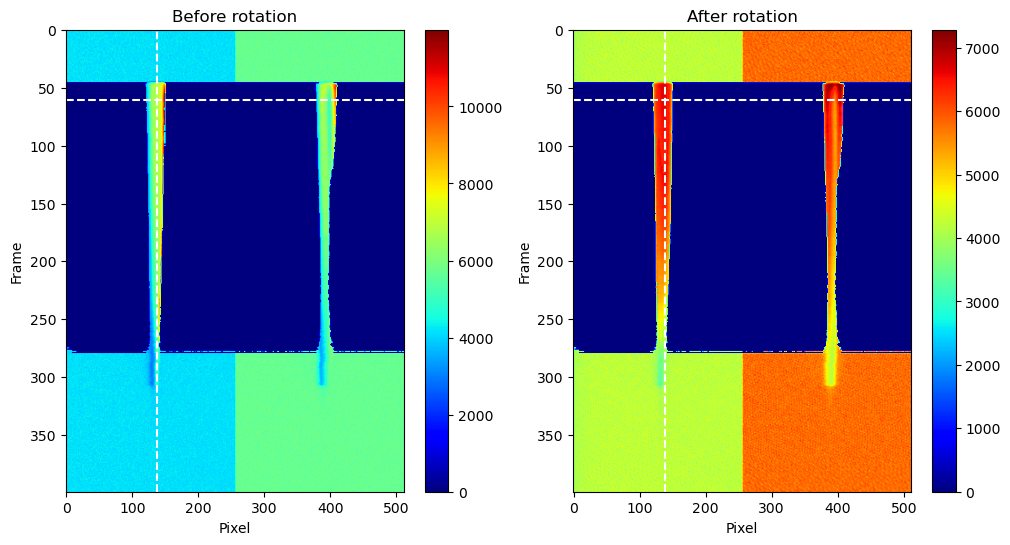

In [16]:
# それぞれの温度変化を見る

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

dists[num1].set_T_data()
dists[num2].set_T_data()

img1 = axes[0].imshow(dists[num1].temp_df, aspect='auto', cmap='jet')
img2 = axes[1].imshow(dists[num2].temp_df, aspect='auto', cmap='jet')

cbar1 = fig.colorbar(img1, ax=axes[0])
cbar2 = fig.colorbar(img2, ax=axes[1])

axes[0].set_title("Before rotation")
axes[1].set_title("After rotation")

for ax in axes:
    ax.axvline(x=pixel, color='white', linestyle='--')
    ax.axhline(y=frame, color='white', linestyle='--')
    ax.set_xlabel("Pixel")
    ax.set_ylabel("Frame")

T1 = dists[num1].temp_df.iloc[frame, pixel]
T2 = dists[num2].temp_df.iloc[frame, pixel]



In [17]:
# hdf5に保存すると、csvと違ってアクセスしたいデータにアクセスでき、高速かつメモリが少ない(PC性能それほどいらない)
with h5py.File(hdf5_name, "r") as f:
    # calibデータの形式は、[Frame, Position_Pixel, Wavelength_Pixel]
    pixel_init = pixel-10
    pixel_end = pixel+10
    spectra1 = f.get('data/calib/dia_noR')[frame, pixel-10:pixel+10, 100:450] # 端を切る
    spectra2 = f.get('data/calib/dia_R')[frame, pixel-10:pixel+10, 100:450]

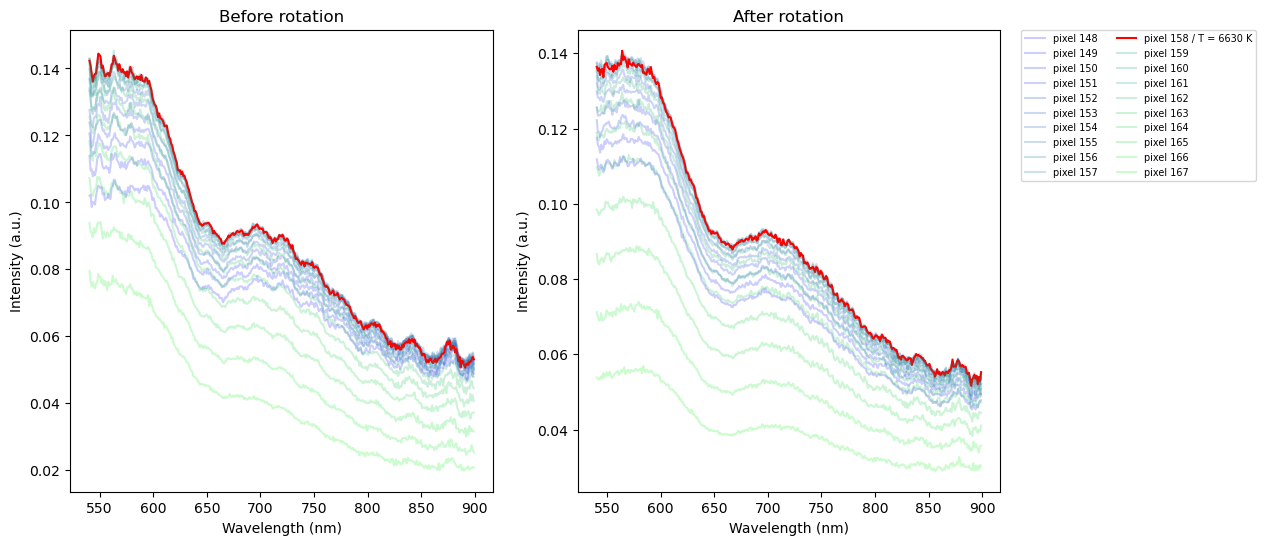

In [18]:
# 回転補正前後のスペクトルを比較する

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

pick = 10 # 選んだpixelのスペクトルを強調するための指定
delta = 20 # 先ほどpixelの前後10ずつを選んだので、合わせて幅が21

ax = axes[0]
for i in range(delta):
    if i == pick:
        c = (1,0,0, 1)
    else:
        c = (0, i/delta, (delta-i)/delta, 0.2)
    ax.plot(wl_arr, spectra1[i, :], color=c)
    ax.set_title(f"Before rotation")

ax = axes[1]
for i in range(delta):
    if i == pick:
        c = (1,0,0, 1)
        label = f"pixel {i + pixel + 10} / T = {round(T2)} K"
    else:
        c = (0, i/delta, (delta-i)/delta, 0.2)
        label=f"pixel {i + pixel + 10}"
    ax.plot(wl_arr, spectra2[i, :], color=c, label=label)
    ax.set_title(f"After rotation")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=7, ncol=2)
for ax in axes:
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Intensity (a.u.)")


## 2. 別の試料とOD / 同じ校正時期: FeO

In [19]:

# 2023後半のFeO加熱実験
num1 = 3

frames = [250, 305] # 輻射スペクトルを見るframe
pixel = 393 # 輻射スペクトルを見るときの中心pixel

spe = spes[num1]
print(f"run: {spe.basename} {spe.filenum} / exp at {spe.date_time.date()} / calib at {spe.calibration_date[:10]}")
print(f"\tOD: {spe.OD}")


run: ERFeO09_ 6 / exp at 2023-11-08 / calib at 2023-09-15
	OD: OD0


dist.csvを読み込み中...
読み込みました


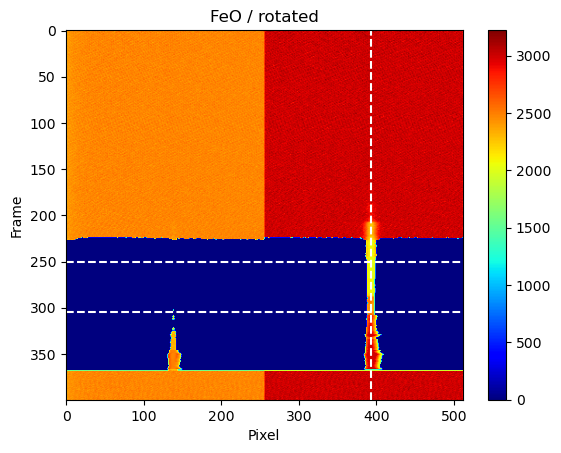

In [20]:

# 温度変化を見る

fig, ax = plt.subplots()

dists[num1].set_T_data()

img1 = ax.imshow(dists[num1].temp_df, aspect='auto', cmap='jet')
cbar1 = fig.colorbar(img1, ax=ax)
ax.set_title("FeO / rotated")

ax.axvline(x=pixel, color='white', linestyle='--')
for frame in frames:
    ax.axhline(y=frame, color='white', linestyle='--')
ax.set_xlabel("Pixel")
ax.set_ylabel("Frame")

T1 = dists[num1].temp_df.iloc[frames[0], pixel]
T2 = dists[num1].temp_df.iloc[frames[1], pixel]



In [21]:

# hdf5に保存すると、csvと違ってアクセスしたいデータにアクセスでき、高速かつメモリが少ない(PC性能それほどいらない)
with h5py.File(hdf5_name, "r") as f:
    # calibデータの形式は、[Frame, Position_Pixel, Wavelength_Pixel]
    pixel_init = pixel-10
    pixel_end = pixel+10
    spectra1 = f.get('data/calib/FeO')[frames[0], pixel-10:pixel+10, 100:450] # 端を切る
    spectra2 = f.get('data/calib/FeO')[frames[1], pixel-10:pixel+10, 100:450]


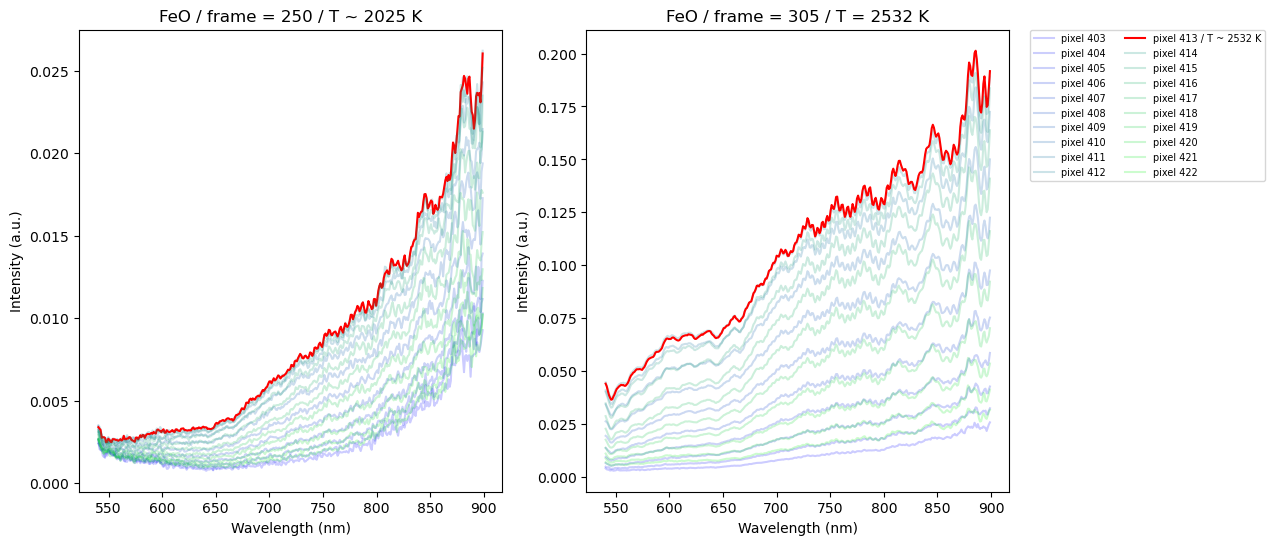

In [22]:

# 温度別のスペクトルを比較する

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

pick = 10 # 選んだpixelのスペクトルを強調するための指定
delta = 20 # 先ほどpixelの前後10ずつを選んだので、合わせて幅が21

ax = axes[0]
for i in range(delta):
    if i == pick:
        c = (1,0,0, 1)
    else:
        c = (0, i/delta, (delta-i)/delta, 0.2)
    ax.plot(wl_arr, spectra1[i, :], color=c)
    ax.set_title(f"FeO / frame = {frames[0]} / T ~ {round(T1)} K")

ax = axes[1]
for i in range(delta):
    if i == pick:
        c = (1,0,0, 1)
        label = f"pixel {i + pixel + 10} / T ~ {round(T2)} K"
    else:
        c = (0, i/delta, (delta-i)/delta, 0.2)
        label=f"pixel {i + pixel + 10}"
    ax.plot(wl_arr, spectra2[i, :], color=c, label=label)
    ax.set_title(f"FeO / frame = {frames[1]}    / T = {round(T2)} K")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=7, ncol=2)
for ax in axes:
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Intensity (a.u.)")


## 3. 別の試料と校正時期 / 同じOD: MgO

In [23]:

# 2022後半のMgO加熱実験
num1 = 1

frames = [50, 80] # 輻射スペクトルを見るframe
pixel = 390 # 輻射スペクトルを見るときの中心pixel

spe = spes[num1]
print(f"run: {spe.basename} {spe.filenum} / exp at {spe.date_time.date()} / calib at {spe.calibration_date[:10]}")
print(f"\tOD: {spe.OD}")


run: OIMgO14 2 / exp at 2022-12-04 / calib at 2022-04-05
	OD: OD6


dist.csvを読み込み中...
読み込みました


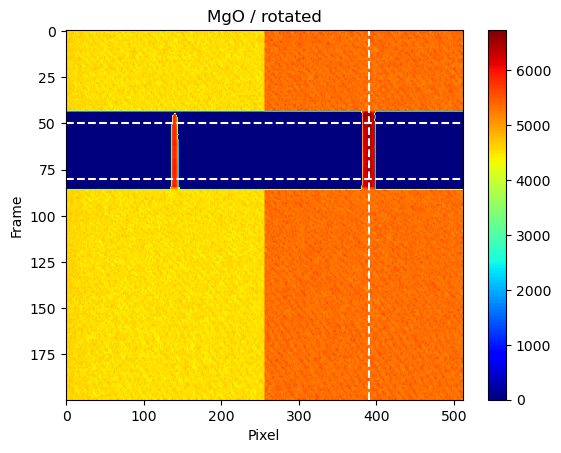

In [24]:


# 温度変化を見る

fig, ax = plt.subplots()

dists[num1].set_T_data()

img1 = ax.imshow(dists[num1].temp_df, aspect='auto', cmap='jet')
cbar1 = fig.colorbar(img1, ax=ax)
ax.set_title("MgO / rotated")

ax.axvline(x=pixel, color='white', linestyle='--')
for frame in frames:
    ax.axhline(y=frame, color='white', linestyle='--')
ax.set_xlabel("Pixel")
ax.set_ylabel("Frame")

T1 = dists[num1].temp_df.iloc[frames[0], pixel]
T2 = dists[num1].temp_df.iloc[frames[1], pixel]



In [25]:

# hdf5に保存すると、csvと違ってアクセスしたいデータにアクセスでき、高速かつメモリが少ない(PC性能それほどいらない)
with h5py.File(hdf5_name, "r") as f:
    # calibデータの形式は、[Frame, Position_Pixel, Wavelength_Pixel]
    pixel_init = pixel-10
    pixel_end = pixel+10
    spectra1 = f.get('data/calib/MgO')[frames[0], pixel-10:pixel+10, 100:450] # 端を切る
    spectra2 = f.get('data/calib/MgO')[frames[1], pixel-10:pixel+10, 100:450]


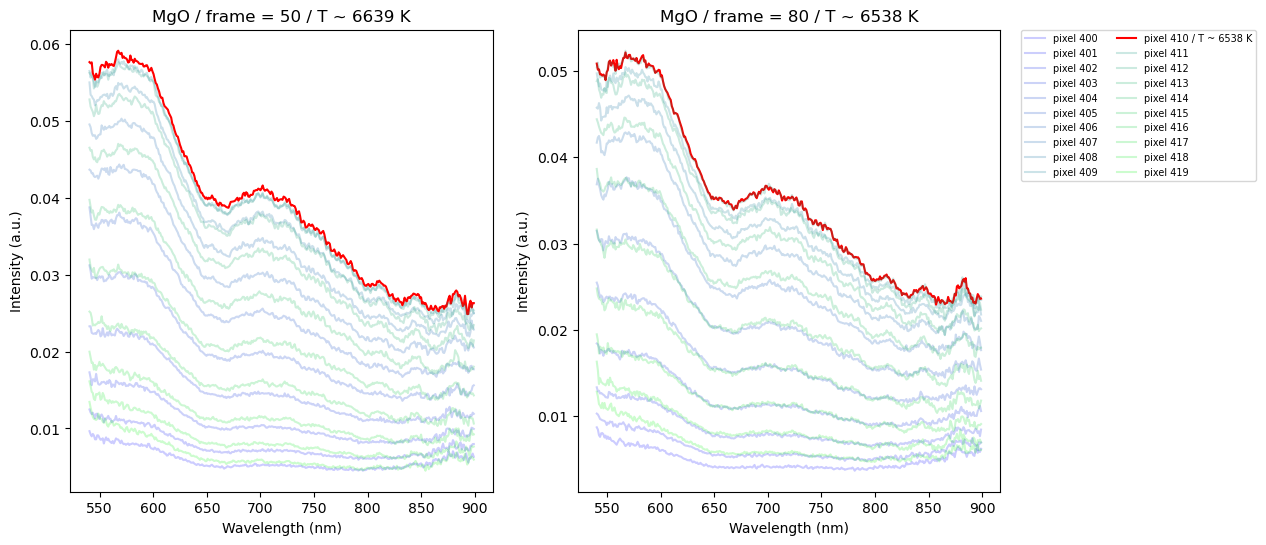

In [29]:

# スペクトルを表示

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

pick = 10 # 選んだpixelのスペクトルを強調するための指定
delta = 20 # 先ほどpixelの前後10ずつを選んだので、合わせて幅が21

ax = axes[0]
for i in range(delta):
    if i == pick:
        c = (1,0,0, 1)
    else:
        c = (0, i/delta, (delta-i)/delta, 0.2)
    ax.plot(wl_arr, spectra1[i, :], color=c)
    ax.set_title(f"MgO / frame = {frames[0]} / T ~ {round(T1)} K")

ax = axes[1]
for i in range(delta):
    if i == pick:
        c = (1,0,0, 1)
        label = f"pixel {i + pixel + 10} / T ~ {round(T2)} K"
    else:
        c = (0, i/delta, (delta-i)/delta, 0.2)
        label=f"pixel {i + pixel + 10}"
    ax.plot(wl_arr, spectra2[i, :], color=c, label=label)
    ax.set_title(f"MgO / frame = {frames[1]} / T ~ {round(T2)} K")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=7, ncol=2)
for ax in axes:
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Intensity (a.u.)")


In [27]:
# 一部をcsvとして書き出す
# 添付する用
